Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import mode
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.ensemble import BaggingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

# import wandb

2024-08-28 19:41:54.830541: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 19:41:54.839165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 19:41:54.849260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 19:41:54.852310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 19:41:54.860068: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# wandb.init(
#   project='kaggle_mushroom',
#   config={
#     "learning_rate": 0.02,
#     "architecture": "CNN",
#     "dataset": "CIFAR-100",
#     "epochs": 10,
#   }
# )

Load Data

In [3]:
train_df = pd.read_csv("data/playground-series-s4e8/train.csv", index_col='id')
orig_df = pd.read_csv("data/secondary-mushroom-dataset-data-set/MushroomDataset/secondary_data.csv", sep=";")
test_df = pd.read_csv("data/playground-series-s4e8/test.csv", index_col='id')
train_df = pd.concat([train_df, orig_df], ignore_index=True) # Combine the competition data with the secondary data

Pre-process Data

In [4]:
# Remove Duplicates
train_df.drop_duplicates(inplace=True)

# Categorize Features
target = 'class'
features = train_df.drop(target, axis=1).columns.to_list()
features_with_high_null_values = [feature for feature in features if (train_df[feature].isna().sum()/len(train_df)*100)>20]
categorical_features = train_df[features].select_dtypes(include='object').columns.to_list()
numerical_features = list(set(features) - set(categorical_features))

In [5]:
''' Impute Missing Values (Null Values) '''

# Clean Categorical Features
def cleaner(df):
    for col in categorical_features:
        df[col] = df[col].fillna('missing')
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < 100, col] = "noise"
        df[col] = df[col].astype('category')

    return df

train_df = cleaner(train_df)
test_df = cleaner(test_df)

# Clean Numerical Features with mean
cap_diameter_mean = pd.concat([train_df['cap-diameter'], test_df['cap-diameter']]).mean(numeric_only=True)
train_df['cap-diameter'].fillna(cap_diameter_mean, inplace=True)
test_df['cap-diameter'].fillna(cap_diameter_mean, inplace=True)

In [6]:
X = train_df.copy()
y = X.pop(target)

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

Prepare Training

In [7]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)
    
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")
    
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [8]:
def model_trainer(model, X, y, test_set, skfold):
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")

    oof_mccs = []
    test_probs = np.zeros((test_set.shape[0],))   # test set probabilities. Average of each fold's probability prediction on test set.
    oof_probs = np.zeros((X.shape[0],))   # training set probabilities

    for fold, (train_idx, val_idx) in enumerate(skfold.split(X, y)):
        # Select train, validation set by each fold
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_val, y_val = X.iloc[val_idx, :], y[val_idx]

        # Train Model
        model = clone(model)
        model.fit(X_train, y_train)

        # Evaluate by validation set
        val_probs = model.predict_proba(X_val)[:, 1]   # Calculate probability
        oof_probs[val_idx] = val_probs   # Save probability of this fold's validation set
        val_preds = (val_probs > 0.5).astype(int)   # Convert probability to label
        mcc = matthews_corrcoef(y_val, val_preds)   # Calculate mcc score
        oof_mccs.append(mcc)   # Save mcc score of this fold's validation set
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")

        # Predict on test set
        test_probs += model.predict_proba(test_set)[:, 1] / skfold.get_n_splits()   # Aggregate test set probabilities

    mean_mcc_score = np.mean(oof_mccs)
    std_mcc_score = np.std(oof_mccs)
    print(f"\n---> Mean MCC Score: {mean_mcc_score:.6f} \xb1 {std_mcc_score:.6f}\n\n")
    
    total_mcc_score = matthews_corrcoef(y, (oof_probs > 0.5).astype(int))
    print(f"Total MCC Score: {total_mcc_score:.6f}")

    return oof_mccs, test_probs, oof_probs

Baseline Models

In [9]:
''' tree-based models '''

xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")
cat_clf = CatBoostClassifier(
    cat_features=categorical_features,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)
lgb_clf = LGBMClassifier(device='gpu', verbosity=-1)

In [10]:
''' Neural Network models '''

# Neural network (Keras) with two hidden layers (one-hot encoded)
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(512, activation='linear'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.36))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.24))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.16))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.12))
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

display(keras.utils.plot_model(get_model({"X_shape_": X.shape}),
                       show_shapes=True, show_layer_activations=True, dpi=80))


nn_clf = KerasClassifier(
    get_model,
    loss="binary_crossentropy",
    optimizer=keras.optimizers.AdamW(learning_rate=0.01),
    validation_split=0.03,
    batch_size=8192,
    validation_batch_size=65536,
    epochs=53,
    # verbose=0, # or 2
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3),
               keras.callbacks.EarlyStopping(patience=5, min_delta=0.00003)]
)

nn_model = make_pipeline(ColumnTransformer([
                                        ('float', make_pipeline(PowerTransformer(),
                                                                 SimpleImputer(add_indicator=True)),
                                          numerical_features),
                                         ('cat', OneHotEncoder(drop='first',
                                                               sparse_output=False,
                                                               dtype=np.float32,
                                                               handle_unknown='infrequent_if_exist',
                                                               min_frequency=50),
                                          categorical_features),
                                        ]),
                      StandardScaler(),
                      BaggingClassifier(nn_clf, n_estimators=7, bootstrap=False))
# cross_validate(nn_model, 'Keras')

I0000 00:00:1724841731.921709   25478 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724841731.945368   25478 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724841731.946740   25478 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724841731.948599   25478 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

You must install pydot (`pip install pydot`) for `plot_model` to work.


None

Hyper Parameters

In [11]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_features
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
    # 'device': 'gpu',
    'verbosity': -1
}

Train Base Model

In [12]:
# %% time
cv_summary, test_probs, oof_probs = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
random_state = 101
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

In [13]:
cv_summary['xgb'], test_probs['xgb'], oof_probs['xgb'] = model_trainer(XGBClassifier(**xgb_params), X, y, test_df, skfold)

Training XGBClassifier
--- Fold 1 MCC Score: 0.984879
--- Fold 2 MCC Score: 0.984927
--- Fold 3 MCC Score: 0.984749
--- Fold 4 MCC Score: 0.984930
--- Fold 5 MCC Score: 0.984882

---> Mean MCC Score: 0.984873 ± 0.000066


Total MCC Score: 0.984873


In [14]:
cv_summary['cat'], test_probs['cat'], oof_probs['cat'] = model_trainer(CatBoostClassifier(**cat_params), X, y, test_df, skfold)

Training CatBoostClassifier


--- Fold 1 MCC Score: 0.984749


--- Fold 2 MCC Score: 0.984860


--- Fold 3 MCC Score: 0.984470


--- Fold 4 MCC Score: 0.984838


--- Fold 5 MCC Score: 0.984675

---> Mean MCC Score: 0.984718 ± 0.000140


Total MCC Score: 0.984718


In [15]:

cv_summary['lgb'], test_probs['lgb'], oof_probs['lgb'] = model_trainer(LGBMClassifier(**lgb_params), X, y, test_df, skfold)

Training LGBMClassifier
--- Fold 1 MCC Score: 0.985025
--- Fold 2 MCC Score: 0.984989
--- Fold 3 MCC Score: 0.984879
--- Fold 4 MCC Score: 0.984977
--- Fold 5 MCC Score: 0.984971

---> Mean MCC Score: 0.984968 ± 0.000048


Total MCC Score: 0.984968


In [16]:
cv_summary['nn'], test_probs['nn'], oof_probs['nn'] = model_trainer(nn_model, X, y, test_df, skfold)

Training Pipeline
Epoch 1/53


I0000 00:00:1724843653.395851   26001 service.cc:146] XLA service 0x7116b8013f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724843653.395870   26001 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-08-28 20:14:13.459836: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 20:14:13.788307: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8905


 42/302 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3602

I0000 00:00:1724843655.995440   26001 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


302/302 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.1359 - val_loss: 0.0247 - learning_rate: 0.0100
Epoch 2/53
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0481 - val_loss: 0.0223 - learning_rate: 0.0100
Epoch 3/53
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0460 - val_loss: 0.0192 - learning_rate: 0.0100
Epoch 4/53
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0439 - val_loss: 0.0190 - learning_rate: 0.0100
Epoch 5/53
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0432 - val_loss: 0.0182 - learning_rate: 0.0100
Epoch 6/53
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0429 - val_loss: 0.0176 - learning_rate: 0.0100
Epoch 7/53
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0424 - val_loss: 0.0185 - learning_rate: 0.0100
Epoch 8/53
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0422 - val_loss: 0.0183 - learning_rate: 0.0100
Epoch 9/53
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0421 - val_loss: 0.0187 - learning_rate: 0.0100
Epoch 10/53
302/302 

In [17]:
# Performance Summary for comparing model (Not Needed)
transposed_df = cv_summary.transpose()
transposed_df.columns = ['fold1','fold2','fold3','fold4','fold5']
transposed_df['Mean'] = transposed_df.mean(axis=1)
transposed_df['Std'] = transposed_df.std(axis=1)
transposed_df.sort_values(by = 'Mean', ascending=False).style.background_gradient('Dark2_r')

,fold1,fold2,fold3,fold4,fold5,Mean,Std
lgb,0.985025,0.984989,0.984879,0.984977,0.984971,0.984968,0.000048
xgb,0.984879,0.984927,0.984749,0.984930,0.984882,0.984873,0.000066
cat,0.984749,0.984860,0.984470,0.984838,0.984675,0.984718,0.000140
nn,0.984126,0.984495,0.983919,0.984214,0.983971,0.984145,0.000204


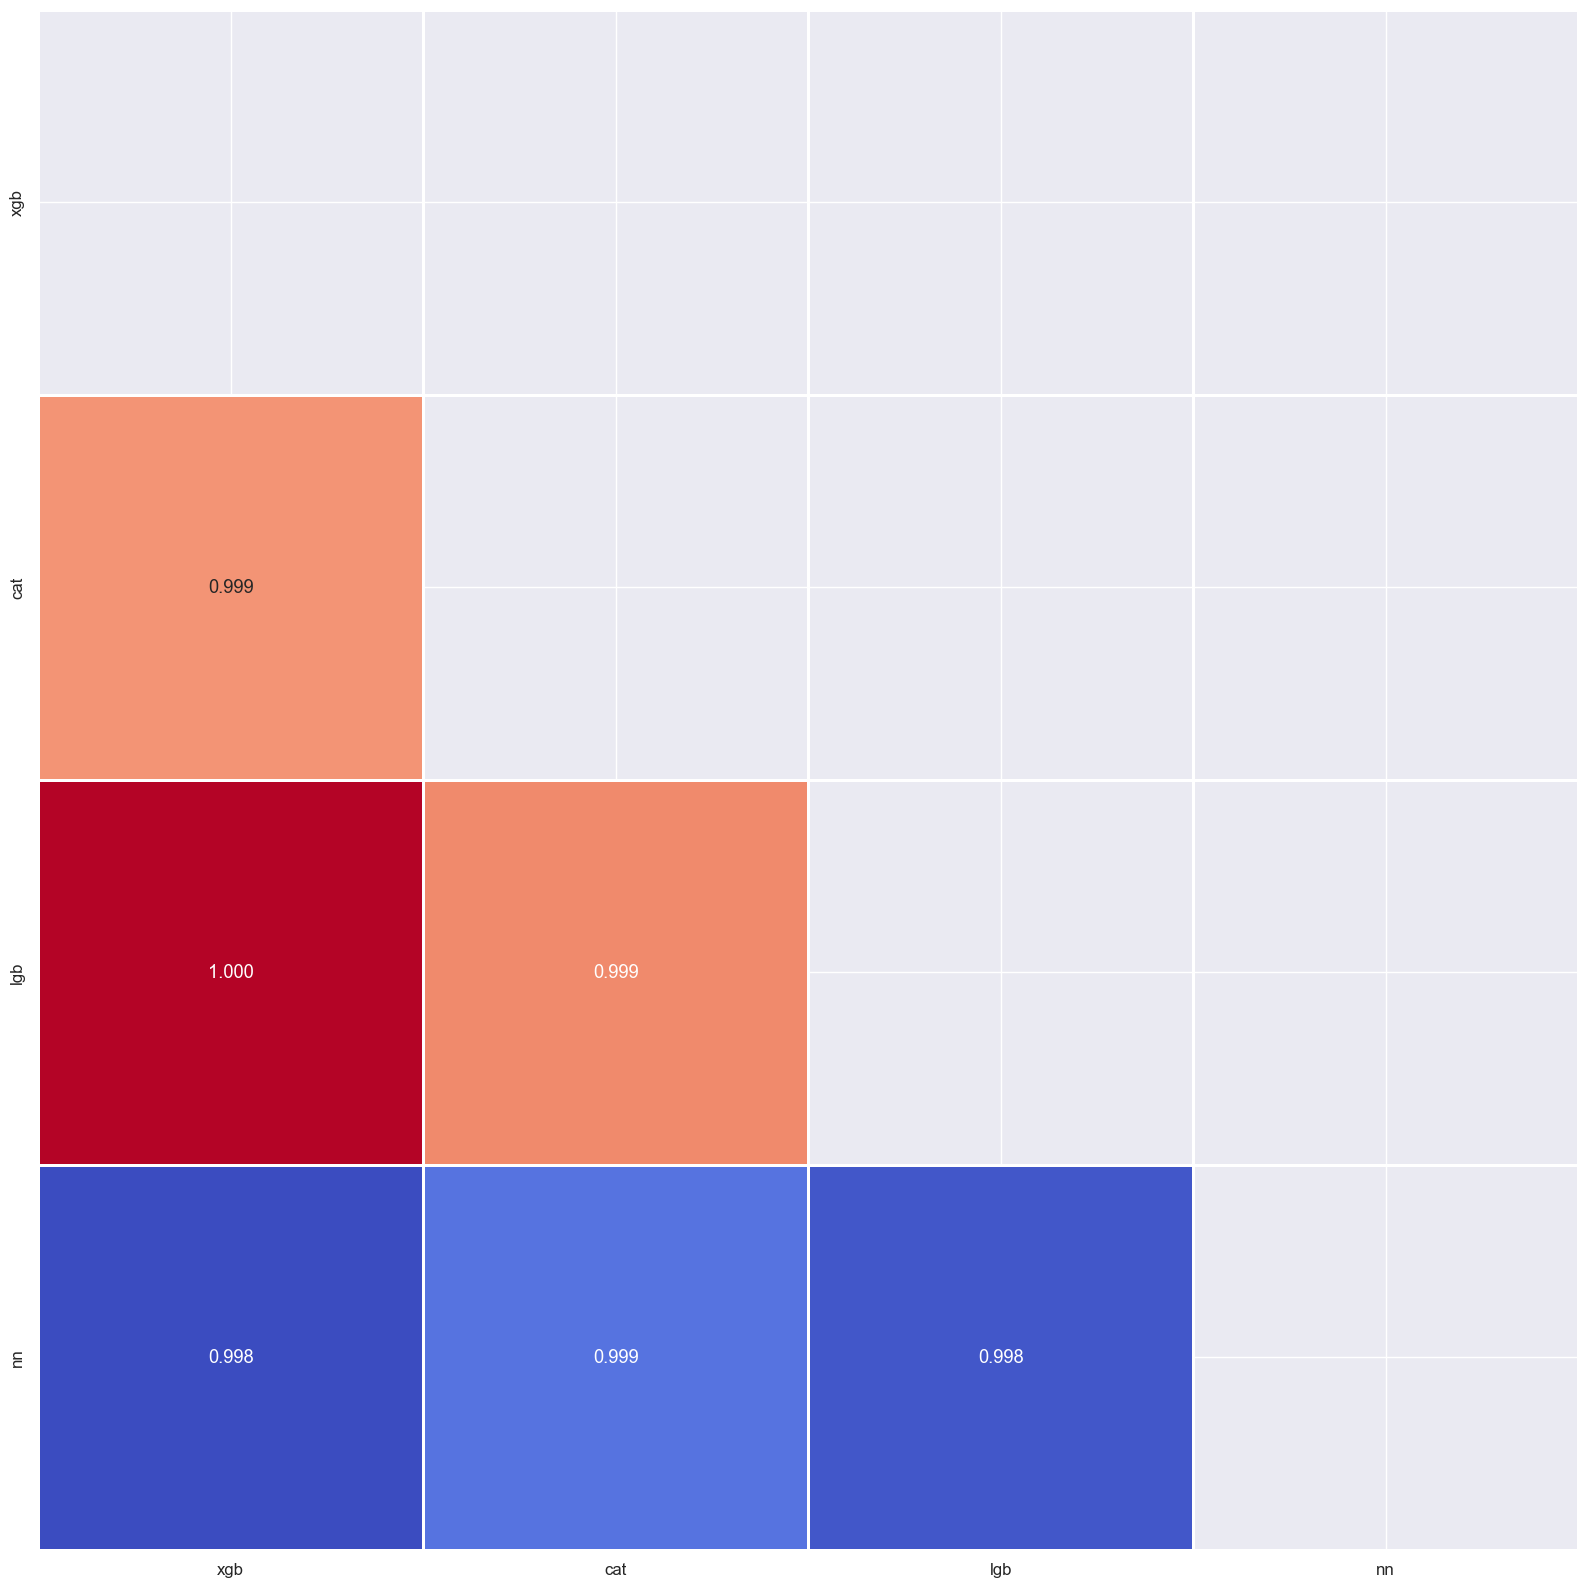

In [18]:
# Model diversity check (Not Needed)
sns.set(font_scale=1.1)
correlation_train = oof_probs.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

### Ensemble

1. Voting

In [19]:
#voting hard & soft
def voting_ensemble(oof_probs, y, threshold=0.5, voting_type='soft'):
    if voting_type == 'soft':
        ensemble_preds = oof_probs.mean(axis=1)
        ensemble_class_preds = (ensemble_preds > threshold).astype(int)
        
    elif voting_type == 'hard':
        binary_preds = (oof_probs > threshold).astype(int)
        ensemble_class_preds = mode(binary_preds, axis=1)[0].flatten()
    
    mcc_score = matthews_corrcoef(y, ensemble_class_preds)
    
    return mcc_score, ensemble_class_preds

In [20]:
soft_vote_score, soft_vote_pred = voting_ensemble(oof_probs, y, voting_type='soft')
print(soft_vote_score)

0.9851378386766322


In [21]:
hard_vote_score, hard_vote_pred = voting_ensemble(oof_probs, y, voting_type='hard')
print(hard_vote_score)

0.9850263211810737


In [22]:
#voting hard & soft
def voting_ensemble_only_pred(oof_probs, threshold=0.5, voting_type='soft'):
  if voting_type == 'soft':
      ensemble_preds = oof_probs.mean(axis=1)
      ensemble_class_preds = (ensemble_preds > threshold).astype(int)
      
  elif voting_type == 'hard':
      binary_preds = (oof_probs > threshold).astype(int)
      ensemble_class_preds = mode(binary_preds, axis=1)[0].flatten()

  return ensemble_class_preds

In [23]:
soft_vote_pred_test = voting_ensemble_only_pred(test_probs, voting_type='soft')

In [24]:
print(soft_vote_pred_test)

0          0
1          1
2          1
3          1
4          0
          ..
2077959    1
2077960    1
2077961    1
2077962    0
2077963    0
Length: 2077964, dtype: int64


2. Stacking

In [25]:
#parameters for meta model                                                                                                 
meta_model_params = {
    'C': 0.000237302749626327,
    'max_iter': 2500,
    'tol': 9.996751434702547e-05,
    'solver': 'saga',
    'penalty': 'l1'
}

meta_model = LogisticRegression(**meta_model_params, random_state=random_state)

In [26]:
# %%time

#Deciding which models to include ensemble

min_features_to_select = 1

# Create a pipeline with preprocessor and RFECV
pipeline = Pipeline([
    ('Scaler', StandardScaler()),
    ('rfecv', RFECV(estimator=meta_model,
                    step=1,
                    cv=skfold,
                    scoring=make_scorer(matthews_corrcoef),
                    min_features_to_select=min_features_to_select,
                    n_jobs=-1,))
])

# Fit the pipeline on oof_preds
pipeline.fit(oof_probs, y)

#CV score
print("Best CV score: ")
selected_models = np.array(oof_probs.columns)[pipeline.named_steps['rfecv'].support_]
print( pipeline.named_steps['rfecv'].cv_results_["mean_test_score"][len(selected_models) - 1])


# Selected models after RFECV
print('Number of available models:', len(oof_probs.columns))
print('Number of selected models for ensemble:', len(selected_models))
print("Selected models:", selected_models)

Best CV score: 
0.9851016234744895
Number of available models: 4
Number of selected models for ensemble: 4
Selected models: ['xgb' 'cat' 'lgb' 'nn']


In [27]:
meta_model = meta_model.fit(oof_probs[selected_models], y)

In [28]:
preds_train =  meta_model.predict(oof_probs[selected_models])
mcc_score = matthews_corrcoef(y, preds_train)
print(mcc_score)

0.985101016973319


In [29]:
preds_test =  meta_model.predict(test_probs[selected_models])
preds_test = lab_enc.inverse_transform(preds_test)

Save Intermediate Result

In [38]:
# cv_summary['lgb'], test_probs['lgb'], oof_probs['lgb']
exp_name = "deep_nn_test1"

from pathlib import Path
Path(f"result/{exp_name}").mkdir(parents=True, exist_ok=True)


cv_summary.to_pickle(f"result/{exp_name}/cv_summary.pkl")
test_probs.to_pickle(f"result/{exp_name}/test_probs.pkl")
oof_probs.to_pickle(f"result/{exp_name}/oof_probs.pkl")

Submission

In [30]:
''' Stacking '''

output = pd.DataFrame({'id': test_df.index,
                       'class': preds_test})
output.to_csv('pred/submission.csv', index=False)

In [31]:
# ''' Soft Voting '''
# soft_vote_pred_test = lab_enc.inverse_transform(soft_vote_pred_test)
# output = pd.DataFrame({'id': test_df.index,
#                        'class': soft_vote_pred_test})
# output.to_csv('pred/submission_soft_vote_1.csv', index=False)

In [32]:
# output.head()

In [33]:
# #save oofs and test predictions for later usage
# oof_probs.to_parquet('oof_predictions_v01.parquet', index=False)
# test_probs.to_parquet('test_predictions_v01.parquet', index=False)

In [34]:
# sub = pd.read_csv("/data/playground-series-s4e8/sample_submission.csv")
# preds = [pred for model, pred in oof_preds.items()]
# md = mode(preds, axis=0)[0] if len(preds)>1 else preds[0]
# sub[target] = lab_enc.inverse_transform(md)
# sub.to_csv("submission.csv", index=False)

In [35]:
# ext1 = pd.read_csv("/kaggle/input/mario-s-nightmare-15-th-place-solution/submission.csv")[target].ravel()
# ext2 = pd.read_csv("/kaggle/input/ps4e8-binary-class-mathews-correlation-coeff/submission.csv")[target].ravel()
# ext3 = pd.read_csv("/kaggle/input/playgrounds4e08-modeblend/submission.csv")[target].ravel()
# ext4 = pd.read_csv("/kaggle/input/autogloun-t8-dslanders/submission.csv")[target].ravel()
# ext5 = pd.read_csv("/kaggle/input/mario-s-nightmare-denselight-0-990/submission_test7.csv")[target].ravel()

# preds = [ext1, ext2, ext3, ext4, ext5]
# preds = [lab_enc.transform(x) for x in preds]
# md = mode(preds, axis=0)[0]
# sub[target] = lab_enc.inverse_transform(md)
# sub.to_csv("submission.csv", index=False)